In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import analysis_utils as aute

In [2]:
rdm_th = 0
corr_th = 0.85

In [3]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 162


In [4]:
def include_time_columns(data, col_name):
    
    return {
        "Mean_" + col_name: np.nanmean(data[col_name]) if col_name in data.columns else np.nan,
        "Max_" + col_name: np.nanmax(data[col_name]) if col_name in data.columns else np.nan,
        "Min_" + col_name: np.nanmin(data[col_name]) if col_name in data.columns else np.nan,
        "Diff_" + col_name: (
            data[col_name].dropna().iloc[-1] - data[col_name].dropna().iloc[0] if col_name in data.columns else np.nan
        ),
    }

In [5]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["UnixTimestampEnd"].iloc[-1] - df["UnixTimestampInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, "OpenAItime_s")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, "AWStime_s")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, "S2Ttime_s")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 12.7222 +/- 8.0302 ; Median = 12.0 ; Min. =  3 ; Max. =  42



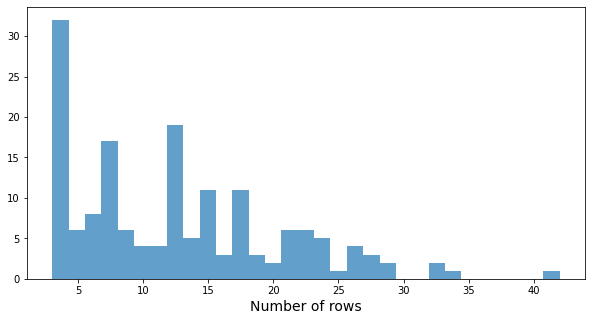

Mean Number of cols = 11.6975 +/- 1.4058 ; Median = 12.0 ; Min. =  10 ; Max. =  15

Mean Time conversation (min) = 1.8013 +/- 1.3603 ; Median = 1.6879 ; Min. =  0.1264 ; Max. =  6.5459



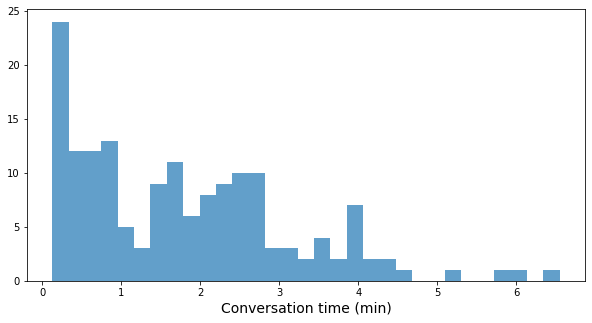

In [6]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.6846 +/- 0.5391 ; Median = 1.5287 ; Min. =  1.1417 ; Max. =  2.9653
Mean Mean_AWStime_s = 0.1104 +/- 0.0315 ; Median = 0.0997 ; Min. =  0.0619 ; Max. =  0.1758
Mean Mean_S2Ttime_s = 1.3355 +/- 0.3366 ; Median = 1.4026 ; Min. =  0.5175 ; Max. =  1.8843


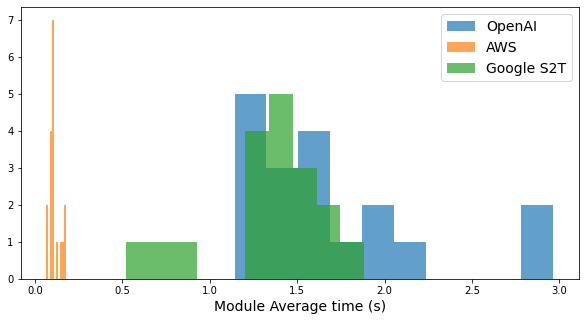

In [7]:
aute.stat_print(df_check["Mean_OpenAItime_s"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWStime_s"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_S2Ttime_s"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAItime_s"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWStime_s"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_S2Ttime_s"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 2.1711 +/- 1.8363 ; Median = 1.456 ; Min. =  0.474 ; Max. =  6.6993
Mean Mean_AWStime_s = -0.1964 +/- 0.0895 ; Median = -0.2302 ; Min. =  -0.2778 ; Max. =  0.0
Mean Mean_S2Ttime_s = 0.3421 +/- 0.4073 ; Median = 0.37 ; Min. =  -0.4513 ; Max. =  1.0048


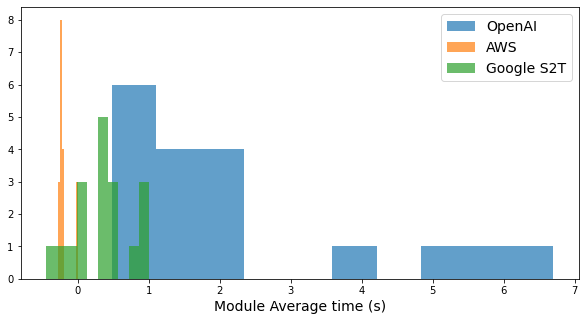

In [8]:
aute.stat_print(df_check["Diff_OpenAItime_s"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Diff_AWStime_s"], "Mean_AWStime_s")
aute.stat_print(df_check["Diff_S2Ttime_s"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Diff_OpenAItime_s"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Diff_AWStime_s"], alpha=0.7, label="AWS")
plt.hist(df_check["Diff_S2Ttime_s"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()